##### Maria Musiał 156062


# Computer vision - Lab 6

## Agenda



* description of pixels based on known image processing methods,
* selection of pixels that best describe the processed image,
* matching key points of multiple images,



## Helpers

In [96]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from numpy.lib.stride_tricks import as_strided
import PIL
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import json
import os
from itertools import product
import itertools
import random

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

### Datasets

In this script we will be using:
*  Image Lenna (available at the [link](http://www.lenna.org/)) - one of the most popular images historically used for testing image processing and compression,
* ARC - The Abstraction and Reasoning Corpus (ARC) - dataset on the task of abstract reasoning by learning models ([link](https://github.com/fchollet/ARC))

In [97]:

# !wget -O lena_std.tif http://www.lenna.org/lena_std.tif
# !wget -O arc.zip https://github.com/fchollet/ARC/archive/refs/heads/master.zip && unzip -q -o arc.zip
# !wget -O chessboard.png https://github.com/opencv/opencv/raw/master/doc/pattern.png
# !wget -O clevr.jpg https://cs.stanford.edu/people/jcjohns/clevr/teaser.jpg
# !wget -O graf1.png https://github.com/opencv/opencv/raw/master/samples/data/graf1.png
# !wget -O graf2.png https://github.com/opencv/opencv/raw/master/samples/data/graf3.png

ARC is a dataset of **task**. A task should be understood as an element consisting of a demonstration of an input and output pair and a query for a given input what is the correct output. Together, they form something like popular intelligence tests where you must demonstrate understanding of some abstract concepts and transformations based on a **demonstration** and apply them to a **query**.

The following code loads data into a Task class object. This class contains the following fields:
* name - file name identical to the task name (unique task identifier),
* demo / test_count - number of demonstrations / queries,
* demo / test_inputs - rasters (NumPy matrices) containing input images showing the task,
* demo / test_outputs - rasters (NumPy matrices) containing output images showing the task,
* demo / test_in_sizes - input images sizes (equal to raster sizes),
* demo / test_out_sizes - output images sizes (equivalent to raster sizes).

**Note:** raster pixels contain numeric data ranging from 0-9, where specific values represent **classes**. The classes are disordered, that is, there is no **<** nor **>** operation.





In [98]:
class Task(object):
    pass


def load_task(dir_name, task_file):
    with open(os.path.join("./ARC-master", "data", dir_name, task_file), "rb") as fp:
        task = json.load(fp)

    def __parse_grid(grid):
        in_grid = np.array(grid["input"], np.int32)
        out_grid = np.array(grid["output"], np.int32)
        return in_grid, out_grid

    obj = Task()
    obj.name = os.path.basename(task_file)
    obj.demo_count, obj.test_count = len(task["train"]), len(task["test"])
    obj.demo_inputs, obj.demo_outputs = list(zip(*map(__parse_grid, task["train"])))
    obj.demo_in_sizes, obj.demo_out_sizes = [i.shape for i in obj.demo_inputs], [
        i.shape for i in obj.demo_outputs
    ]
    obj.test_inputs, obj.test_outputs = list(zip(*map(__parse_grid, task["test"])))
    obj.test_in_sizes, obj.test_out_sizes = [i.shape for i in obj.test_inputs], [
        i.shape for i in obj.test_outputs
    ]
    return obj

In [99]:
def imshow(img):
    img = img.clip(0, 255).astype("uint8")
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img))

In [100]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td {
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 18px;
    height: 18px;
    text-align: center;
    transform: scale(1.0);
    margin: 2px;
    }
</style>
"""


def h(s):
    return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

In [101]:
def h_color(a, cmap="gray", scale=2):
    s = [a.shape[0] * scale, a.shape[1] * scale]
    plt.figure(figsize=s)
    plt.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=False,
        labelleft=False,
        left=False,
        right=False,
    )
    plt.imshow(a, cmap=cmap)
    
    

In [102]:
cmap = ListedColormap(
    [
        "black",
        "tomato",
        "chocolate",
        "darkorange",
        "gold",
        "olive",
        "green",
        "deepskyblue",
        "blueviolet",
        "hotpink",
    ]
)


def h_grid(grid, scale=1):
    h_color(grid, cmap, scale)

# Pixel description (Classic)

An intensity domain or spatial domain 2D image is a 2D projection of a 3D scene, represented as a 2D matrix containing pixels. There are various equivalent notations such as RGB, CMYK, HSV, etc., in which each pixel is written in a different way (using different representations).

Consequently, each representation of a 3D scene describes the incident light on the camera matrix, and pixels serve as **descriptors** for the incident light on a given element.

As each pixel acts as a descriptor for a specific element in the scene, there is a natural correlation between neighboring pixels in the intensity domain, creating a cause-and-effect relationship among them. **This interpretation forms the foundation for numerous pixel description methods based on both the pixel and its neighborhood representations, all designed for analyzing the content of the 3D scene.**

We will refer to any operation that describes a given pixel or its relationship to its neighborhood as a **descriptor**. The term **descriptor(pixel)**  is also used to denote the value returned by the descriptor operation. In essence, a descriptor encompasses a set of features that describe a given object, whether it's the entire image, individual pixels, or a function that generates these features.




## Building descriptors of simple features

By loading an image into memory in the form of a 2D raster, we obtain the first, one of the simpler descriptors. Each pixel is described with 3 values determining the "content" of blue, green and red colors.


In [ ]:
lena = cv2.imread("./lena_std.tif", 1)

print("Each pixel is described by 3 values", lena.shape, lena[10, 10])
imshow(lena)

Another descriptor may be the form "grayscale", in which each pixel has an associated grayscale value. It is one value between 0-255.

In [ ]:
lena_gray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)

print("Each pixel is described by 1 value", lena_gray.shape, lena_gray[10, 10])
imshow(lena_gray)

Having many descriptors for a given pixel, we can combine them or create new descriptors based on them. One of the simpler operations of folding descriptors is to append values from all descriptors to form one longer vector.

Below is presented a descriptor that combines an image in BGR and Grayscale space, as a result describing each pixel with four values (Blue, Green, Red, Grayscale).


In [105]:
def simpliest_possible_descriptor(img):
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
    return np.concatenate([img, img_grayscale], -1)

In [106]:
lena_spd = simpliest_possible_descriptor(lena)
print("Each pixel is described by 4 values", lena_spd.shape, lena_spd[10, 10])

Each pixel is described by 4 values (512, 512, 4) [113 131 226 157]


From the previously known (convolutional) image filtering methods, we can distinguish low-pass and high-pass filters. Below is an example of creating two descriptors composed of low pass and high pass filter values.


In [107]:
def high_pass_filter_descriptor(img):
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_laplacian = cv2.Laplacian(img_grayscale, cv2.CV_32F)
    img_sobel = cv2.Sobel(img_grayscale, cv2.CV_32F, 1, 1, ksize=3)
    return np.stack([img_laplacian, img_sobel], -1)


def low_pass_filter_descriptor(img):
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.blur(img_grayscale, (3, 3))
    img_gaussian_blur = cv2.GaussianBlur(img_grayscale, (5, 5), 0)
    img_median = cv2.medianBlur(img_grayscale, 5)
    img_bilateral = cv2.bilateralFilter(img_grayscale, 9, 75, 75)
    return np.stack([img_blur, img_gaussian_blur, img_median, img_bilateral], -1)

In [108]:
lena_lpf = low_pass_filter_descriptor(lena)
print("Low pass filter descriptor:", lena_lpf.shape, lena_lpf[10, 10])

lena_hpf = high_pass_filter_descriptor(lena)
print("High pass filter descriptor:", lena_hpf.shape, lena_hpf[10, 10])

Low pass filter descriptor: (512, 512, 4) [157 157 157 157]
High pass filter descriptor: (512, 512, 2) [-2. -4.]


Descriptors can be based on any operation. These can be both complex operations based on machine learning systems, as well as precise algorithms describing specific, previously known concepts.

In the example of an image (any image) in ARC below, the following method describes the neighborhood of a given pixel.



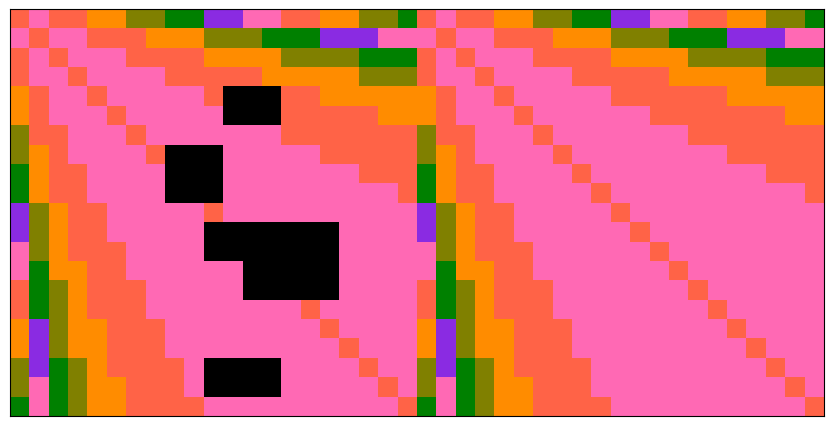

In [109]:
p_73251a56 = load_task("training", "73251a56.json")
h_grid(
    np.concatenate([p_73251a56.demo_inputs[0], p_73251a56.demo_outputs[0]], 1),
    scale=0.5,
)


The method involves checking whether the adjacent pixel, located at the specified position, is the same as the central pixel.

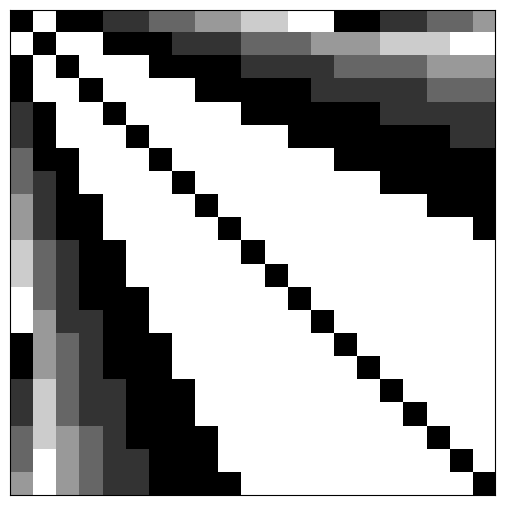

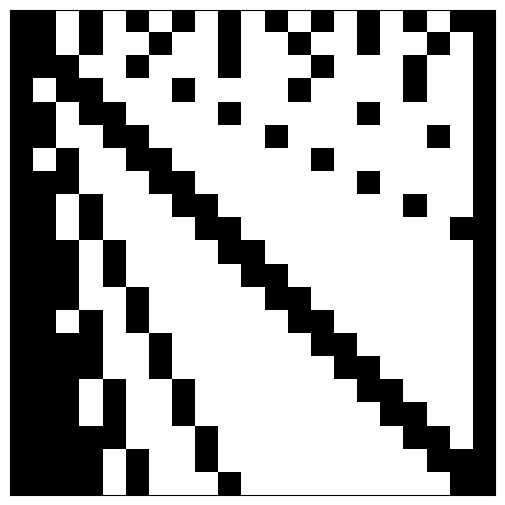

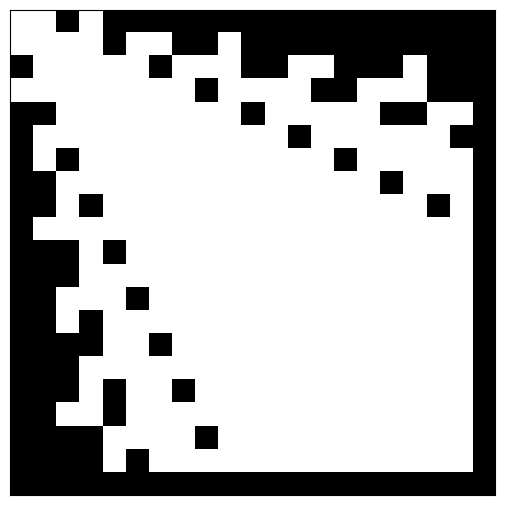

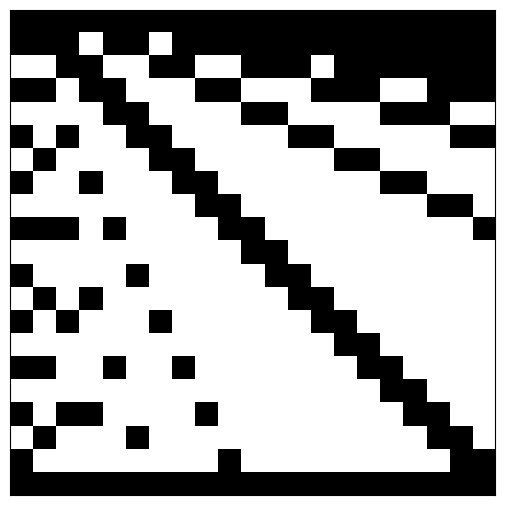

In [110]:
def check_neighbour(img, pos, neighbourhood_size=3):
    # parameters requirements
    assert neighbourhood_size % 2 == 1
    center = int((neighbourhood_size - 1) / 2)
    assert pos[0] != 0 or pos[1] != 0
    assert (0 <= center + pos[0] < neighbourhood_size) and (
        0 <= center + pos[1] < neighbourhood_size
    )

    # prepare filter for conv2d where center pixel == -1 and selected neighbour == 1
    kernel = np.zeros([neighbourhood_size, neighbourhood_size])
    kernel[center, center] = -1
    kernel[center + pos[0], center + pos[1]] = 1

    # perform conv2d and find pixels where center + neighbour == 0
    img_n = cv2.filter2D(
        img.astype(np.float32),
        -1,
        kernel.astype(np.float32),
        borderType=cv2.BORDER_ISOLATED,
    )
    img_n = img_n == 0  #values true if pixel == 0, false otherwise

    return img_n

h_color(p_73251a56.demo_outputs[0].astype(np.uint8), scale=0.3)
h_color(check_neighbour(p_73251a56.demo_outputs[0], (0, 1)).astype(np.uint8), scale=0.3)  #if one on the right is the same, set 0
h_color(check_neighbour(p_73251a56.demo_outputs[0], (1, 1)).astype(np.uint8), scale=0.3)  #if one on the right and one down is the same, set 0
h_color(check_neighbour(p_73251a56.demo_outputs[0], (1, 0)).astype(np.uint8), scale=0.3) #if one down is the same, set 0 -> will figure out diagonals

### Task 1

For any ARC image, suggest a descriptor that will calculate the number of the same adjacent pixels as the center pixel.

Then find the pixels they will have:
- exactly 4 same neighbors,
- more than 4 same neighbors

Parameters:
- create a 3x3 neighborhood





A pixel descriptor that specifies the number of identical neighbors:



Input raster and descriptors found


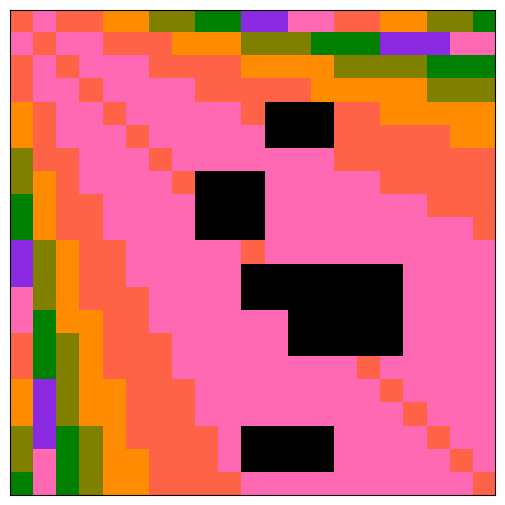

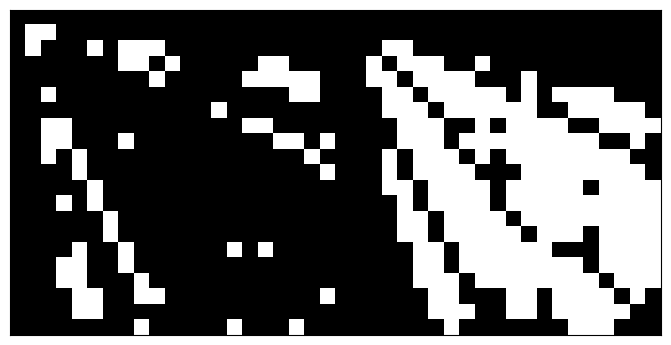

In [111]:
from scipy.signal import convolve2d

def neighbourhood_descriptor(img):
    # Get the unique values in the image
    unique_values = np.unique(img)
    
    # Define the 3x3 kernel for adjacency (excluding center pixel)
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.uint8)
    
    result = np.zeros_like(img, dtype=np.uint8)
    
    for value in unique_values:
        # Create a binary mask for the current value
        mask = (img == value).astype(np.uint8)
        
        # Count the adjacent pixels with the same value using convolution
        # adjacent_count = convolve2d(mask, kernel, mode='same', boundary='fill', fillvalue=0)   #scipy version
        adjacent_count = cv2.filter2D(mask, -1, kernel, borderType=cv2.BORDER_CONSTANT)
        
        #Update the pixels of the value with count
        result += (img == value) * adjacent_count
    
    return result


demo_output = p_73251a56.demo_inputs[0]
demo_output_n = neighbourhood_descriptor(demo_output)

print("A pixel descriptor that specifies the number of identical neighbors:")
h(demo_output_n)

print("\nInput raster and descriptors found")
h_grid(demo_output, scale=0.3)
h_color(np.concatenate([demo_output_n == 4, demo_output_n > 4], 1), scale=0.4)

## Detection and matching of key points

The purpose of the descriptors is to succinctly describe the image in such a way that it is possible to identify essential characteristics that facilitate **comparison with other images**.

**Global Descriptor**: A global descriptor characterizes the entire image as a whole. Creating a good global descriptor is challenging because it must capture all crucial information while maintaining a compact size. This process is essentially a task of compression, and it is sensitive to changes in any part of the image, which can significantly impact the descriptor and lead to potential mismatches.

The entire image, represented by all its pixels, can serve as a global descriptor. However, comparing images pixel by pixel is highly inefficient and extremely sensitive to transformations such as scaling, rotation, or noise.

**Local Descriptor**: A local descriptor provides a concise representation of a point's surrounding neighborhood. It focuses on capturing the shape and appearance of the immediate area around the point, making it highly effective for matching purposes within that specific context.

Generating descriptors for every pixel can be computationally inefficient and time-consuming.

Moreover, images often include regions composed of identical or closely resembling pixels, making it unfeasible to match such regions across images.

The solution is to identify distinctive points within the image, known as **key points**.
Key points represent unique or discernible locations in an image, making them easily identifiable across different images.

The process of comparing images based on key points is termed keypoint matching. This involves comparing the key points between both images (point-to-point) and determining the closest key point in the second image for each input key point.

There is also a variation where we discover **multiple matches** for each input key point.


### Detection of key points

The key point detection mechanism is closely related to the descriptor itself. For example, for the Laplasian edge detection, it can be proposed to find pixels with extreme values (e.g. -4 and 4).

For an ARC image, let's define a descriptor that counts adjacent pixels **different** from the center pixel.

**Note: The descriptor is based on the solution of Task 1.**

In [112]:
def not_neighbourhood_descriptor(img):
    return 8 - neighbourhood_descriptor(img)


p_73251a56_in0 = p_73251a56.demo_inputs[0]
p_73251a56_in0_nn = not_neighbourhood_descriptor(p_73251a56_in0)

print("Pixel descriptor specifying the number of different neighbors:")
h(p_73251a56_in0_nn)

Pixel descriptor specifying the number of different neighbors:


A key point is one where the neighbors have great variety in color, class from the key point.
Let's only select pixels that have at least 6 different pixels and are not at the border of the image.

In [113]:
p_73251a56_in0_sel = p_73251a56_in0_nn >= 7
p_73251a56_in0_sel[0, :] = False
p_73251a56_in0_sel[-1, :] = False
p_73251a56_in0_sel[:, 0] = False
p_73251a56_in0_sel[:, -1] = False

print("Key points (matrix):")
h(p_73251a56_in0_sel.astype(np.uint8))

kp = np.where(p_73251a56_in0_sel)

print("\nKey pointse (x, y):")
print("Number of key points:", len(kp[0]))
print("x:", kp[0])
print("y:", kp[1])

Key points (matrix):



Key pointse (x, y):
Number of key points: 24
x: [ 1  1  1  1  1  1  1  1  2  2  3  7  7 10 10 12 13 14 15 15 16 18 18 19]
y: [ 7 10 12 13 15 16 18 19 14 18 12  1  7  1 10  1  1  2  1 15  1  1  2  1]


In [ ]:
for xi, yi in zip(*kp):
    h_grid(p_73251a56_in0[xi - 1 : xi + 2, yi - 1 : yi + 2])
# plt.close('all')

### Matching key points

Next, let's define another descriptor which is a vector of its neighbors.

In [115]:
def copy_descriptor(arr):
    shape = list(arr.shape)
    arr = np.pad(arr, 1, "constant")
    nDims = len(arr.shape)

    newStrides = arr.strides + arr.strides
    return as_strided(arr, shape=shape + [3, 3], strides=newStrides).reshape(
        shape + [9]
    )


p_73251a56_in0_nncopy = copy_descriptor(p_73251a56_in0)

print("Sample pixel neighbors")
print(p_73251a56_in0[0:3, 0:3])

print("\nPixel descriptor with position (1, 1) containing its neighborhood")
print(p_73251a56_in0_nncopy[1, 1])

Sample pixel neighbors
[[1 6 1]
 [6 1 6]
 [1 6 1]]

Pixel descriptor with position (1, 1) containing its neighborhood
[1 6 1 6 1 6 1 6 1]



For all detected key points in the previous section, let's get the corresponding descriptors as calculated above.

In [116]:
desc = np.stack([p_73251a56_in0_nncopy[xi, yi] for xi, yi in zip(*kp)], 0)


Now let's perform analogous transformations for another image from the same ARC task.

In [117]:
p_73251a56_out0 = p_73251a56.demo_outputs[0]
p_73251a56_out0_nn = not_neighbourhood_descriptor(p_73251a56_out0)
p_73251a56_out0_sel = p_73251a56_out0_nn >= 7
p_73251a56_out0_sel[0, :] = False
p_73251a56_out0_sel[-1, :] = False
p_73251a56_out0_sel[:, 0] = False
p_73251a56_out0_sel[:, -1] = False

p_73251a56_out0_nncopy = copy_descriptor(p_73251a56_out0)

kp_ = np.where(p_73251a56_out0_sel)
desc_ = np.stack([p_73251a56_out0_nncopy[xi, yi] for xi, yi in zip(*kp_)], 0)

print("\nKey points (x, y):")
print("Number of key points:", len(kp_[0]))
print("x:", kp_[0])
print("y:", kp_[1])
print(desc_)


Key points (x, y):
Number of key points: 20
x: [ 1  1  1  1  1  1  1  1  2  2  7 10 12 13 14 15 16 18 18 19]
y: [ 7 10 12 13 15 16 18 19 14 18  1  1  1  1  2  1  1  1  2  1]
[[3 3 4 1 2 2 1 1 1]
 [4 5 5 2 3 3 1 2 2]
 [5 6 6 3 3 4 2 2 2]
 [6 6 1 3 4 4 2 2 3]
 [1 1 2 4 4 5 3 3 3]
 [1 2 2 4 5 5 3 3 3]
 [2 3 3 5 5 6 3 4 4]
 [3 3 4 5 6 6 4 4 4]
 [4 4 4 2 3 3 2 2 2]
 [5 5 6 3 4 4 2 3 3]
 [3 1 1 3 2 1 4 2 1]
 [4 2 1 5 3 2 5 3 2]
 [5 3 2 6 3 2 6 4 2]
 [6 3 2 6 4 2 1 4 3]
 [4 2 2 4 3 2 4 3 2]
 [1 4 3 1 4 3 2 5 3]
 [1 4 3 2 5 3 2 5 3]
 [2 5 3 3 5 4 3 6 4]
 [5 3 2 5 4 3 6 4 3]
 [3 5 4 3 6 4 4 6 4]]


In [ ]:
for xi, yi in zip(*kp_):
    h_grid(p_73251a56_out0[xi - 1 : xi + 2, yi - 1 : yi + 2])

Therefore, in the case of two images, we identify their respective key points and generate an additional descriptor designed to effectively characterize a given pixel and its surroundings.

The subsequent phase in the matching process involves defining the matching function. The choice of the matching function is closely tied to the behavior of the descriptor. When dealing with data residing in the same space, it's possible to propose a **distance / similarity function** for the two descriptors (e.g., in a Euclidean space, you can compute the Euclidean distance between the two vectors).

For the given configuration, where the pixel descriptor is based on its neighboring pixels arranged in a specific order, we can propose a similarity function that calculates the percentage of shared components between the two descriptors.+


In [119]:
def nn_sim(desc1, desc2):
    return (desc1 == desc2).mean(-1)


a = np.array([0, 5, 2, 4, 9])
b = np.array([0, 5, 1, 4, 0])

print(nn_sim(a, b))
print(nn_sim(a, a))

0.6
1.0


In [120]:
desc_sim = nn_sim(desc[:, np.newaxis], desc_[np.newaxis])
print("The size of the similarity matrix:", desc_sim.shape)

print("\nSimilarities for the first input key point:")
print(desc_sim[0])

desc_nearest = np.argmax(desc_sim, -1)
desc_nearest_sim = np.max(desc_sim, -1)
print("\nBest matches:", desc_nearest)
print("\nBest matches similarities:\n", desc_nearest_sim)

The size of the similarity matrix: (24, 20)

Similarities for the first input key point:
[1.         0.11111111 0.         0.         0.         0.
 0.11111111 0.33333333 0.11111111 0.         0.33333333 0.11111111
 0.22222222 0.33333333 0.11111111 0.11111111 0.         0.
 0.11111111 0.22222222]

Best matches: [ 0  1  2  3  4  5  6  7  8  9 14 10  2 11 12 12 13 14 15 12 16 17 18 19]

Best matches similarities:
 [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.33333333 1.
 0.22222222 1.         0.22222222 1.         1.         1.
 1.         0.22222222 1.         1.         1.         1.        ]


In [ ]:
for xi, yi, nearest, nearest_sim in zip(*kp, desc_nearest, desc_nearest_sim):
    xi_, yi_ = kp_[0][nearest], kp_[1][nearest]

    query = p_73251a56_in0[xi - 1 : xi + 2, yi - 1 : yi + 2]
    match = p_73251a56_out0[xi_ - 1 : xi_ + 2, yi_ - 1 : yi_ + 2]

    print("Similarity:", nearest_sim)
    h_grid(np.concatenate([query, match], 1))

For the above results, the following facts can be noted:
- each input key point has **always** assigned a key point from the second image,
- the best matches may be low in terms of similarities,
- not necessarily each of the key points from the second image is an mapping to any input key point or it can be mapped to several input key points.

Therefore, matches should only occur if the similarity is greater than a certain threshold.


In [122]:
threshold = 0.7

matches = [
    (i, j)
    for i, j in zip(range(len(desc_nearest)), desc_nearest)
    if desc_nearest_sim[i] > threshold
]

print(len(matches))
print(matches)

20
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (11, 10), (13, 11), (15, 12), (16, 13), (17, 14), (18, 15), (20, 16), (21, 17), (22, 18), (23, 19)]


To assess the similarity between two images, we can introduce additional metrics to measure their similarity, including:
- The count of input key points that have matches.
- The count of reference key points that serve as matches.

In [123]:
in_kp_score = len(matches) / len(kp[0])  #how many kp are above threshold of similarity
ref_kp_score = len(set([j for _, j in matches])) / len(kp_[0])  #how many unique matches- if some kp has >1 match then its bad

print(in_kp_score)
print(ref_kp_score)


0.8333333333333334
1.0


Finally, to find out if the images are similar or not, you can add a condition on the similarity statistics calculated above. The simplest condition will be the cut off condition:

In [124]:
is_similar = in_kp_score > 0.8 and ref_kp_score > 0.8
print(is_similar)


True


## Task 2


Write an algorithm that finds all similar images for the input image (query) and the reference image set. The algorithm should specify the following steps:
- determination of key points,
- transformation of the query image into a list of key points and their descriptors,
- transformation of the reference image set into a set of lists of key points and their descriptors,
- matching the key points of the query and the reference image and determining the similarity,
- displaying the most similar image from the reference set

**Note:**

- it is not allowed to use ready-made descriptors implementations available in the OpenCV library,
- the algorithm can use the materials presented in the sections above, however, **the descriptor should be different and implemented individually**
(building a good descriptor can be really demanding),
- as a data set, you can take input images from several ARC task as a reference set, and any **other** ARC image as a query.




In [125]:
import numpy as np
from scipy.ndimage import convolve
from numpy.lib.stride_tricks import sliding_window_view
from typing import Tuple, List, Any


p_73= load_task("training", "73251a56.json")
p_77 = load_task("training", "776ffc46.json")  
p_dc = load_task("training", "dc0a314f.json") 
p_1c = load_task("training", "1c786137.json") 
p_d0 = load_task("training", "d06dbe63.json") 

image1_out = p_73.demo_outputs[0]
image2_out = p_77.demo_outputs[0]
image3_out = p_dc.demo_outputs[0]
image4_out = p_1c.demo_outputs[0]
image5_out = p_d0.demo_outputs[0]

image1_in = p_73.demo_inputs[0]
image2_in = p_77.demo_inputs[0]
image3_in = p_dc.demo_inputs[0]
image4_in = p_1c.demo_inputs[0]
image5_in = p_d0.demo_inputs[0]


In [126]:
#Idea is to have histogram of occurences of classes withing neighbourhood.
#Idea behind keypoints is that keypoints should be unique regions. 
#Smooth regions will have histograms dominated by a few classes, while more complex textures will show a more even distribution across classes.

def histogram_descriptor(image: np.ndarray, bins: int = 10) -> np.ndarray:
    """
    Compute a histogram descriptor for each pixel in the image. Return number of unique classes in the neighbourhood.
    
    Returns: 
        np.ndarray: 2D array where each pixel value represents the number of unique classes in the neighbourhood.
    """
    kernel = np.ones((3, 3), np.uint8)
    img_pad = np.pad(image, 1, mode='edge') #extend edges for padding
    nieghbourhoods = sliding_window_view(img_pad, kernel.shape)
    nieghbourhoods = nieghbourhoods.reshape(-1, 3*3)  #2D array where each row is a neighbourhood
    
    histograms = np.zeros((nieghbourhoods.shape[0], bins))
    for i in range(bins):
        histograms[:, i] = np.sum(nieghbourhoods == i, axis=1)
    
    unique_count = np.sum(histograms > 0, axis=1)
    return unique_count.reshape(image.shape)

hist = histogram_descriptor(image1_out)
print(hist)

[[2 2 2 3 3 3 3 4 3 4 4 3 4 4 3 4 4 3 4 4 3]
 [2 2 2 3 3 4 4 4 4 5 5 4 5 5 5 5 5 4 5 4 3]
 [2 2 2 2 2 2 3 3 3 3 3 3 4 4 3 4 4 4 5 4 3]
 [3 3 2 2 2 2 2 2 2 3 3 2 2 3 3 3 3 3 3 3 3]
 [3 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 3 3 2]
 [3 4 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [3 4 3 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 2 2 2]
 [4 4 3 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 1 1]
 [3 4 3 2 2 1 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2]
 [4 5 3 3 2 2 1 2 2 2 2 2 1 1 1 1 1 2 2 2 2]
 [4 5 3 3 2 2 1 1 2 2 2 2 2 1 1 1 1 1 1 2 2]
 [3 4 3 2 2 2 2 1 1 2 2 2 2 2 1 1 1 1 1 1 1]
 [4 5 4 2 3 2 2 1 1 1 2 2 2 2 2 1 1 1 1 1 1]
 [4 5 4 3 2 2 2 2 1 1 1 2 2 2 2 2 1 1 1 1 1]
 [3 5 3 3 2 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 1]
 [4 5 4 3 2 2 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1]
 [4 5 4 3 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 1 1]
 [3 4 4 3 3 2 1 2 2 2 1 1 1 1 1 2 2 2 2 2 1]
 [4 5 5 3 3 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2]
 [4 4 4 3 3 2 2 1 2 2 2 1 1 1 1 1 1 2 2 2 2]
 [3 3 3 3 2 2 2 1 2 2 2 1 1 1 1 1 1 1 2 2 2]]


In [127]:
def hist_keypoints(histogram: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate key points based on the histogram descriptor. Return pixels that 
    have the highest variety of classes in neighbourhood.
    
    Returns: 
        tuple: Tuple of arrays representing the x and y coordinates of keypoints.
    """
    kp = np.where(histogram == np.max(histogram.flatten()))    
    return kp

kps = hist_keypoints(hist)
print("\nKey points (x, y):")
print("x:", kps[0])
print("y:", kps[1])


Key points (x, y):
x: [ 1  1  1  1  1  1  1  1  2  9 10 12 13 14 15 16 18 18]
y: [ 9 10 12 13 14 15 16 18 18  1  1  1  1  1  1  1  1  2]


In [128]:
#We get neighbours of pixel to determine matching. Borrowed this from above code
def copy_descriptor(arr: np.ndarray) -> np.ndarray:
    """ 
    Extract the neighborhood of each keypoint as descriptors. 
    
    Returns: 
        np.ndarray: Array of descriptors where each descriptor is a flattened 3x3 neighborhood. 
    """
    shape = list(arr.shape)
    arr = np.pad(arr, 1, "edge")
    nDims = len(arr.shape)

    newStrides = arr.strides + arr.strides
    return as_strided(arr, shape=shape + [3, 3], strides=newStrides).reshape(
        shape + [9])

#### Transformation of the query image into a list of key points and their descriptors

In [129]:
def get_kps_desc(image: np.ndarray) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """
    Calculate key points and descriptors for the image.
    
    Returns: 
        tuple: Tuple of key points and their descriptors.
    """
    hist = histogram_descriptor(image)
    kps = hist_keypoints(hist)
    img_cpy = copy_descriptor(image)
    desc = np.stack([img_cpy[xi, yi] for xi, yi in zip(*kps)], 0)
    return kps, desc

kps, desc = get_kps_desc(image1_out)
print("\nKey points (x, y):")
print("x:", kps[0])
print("y:", kps[1])
print("Descriptors:\n", desc)


Key points (x, y):
x: [ 1  1  1  1  1  1  1  1  2  9 10 12 13 14 15 16 18 18]
y: [ 9 10 12 13 14 15 16 18 18  1  1  1  1  1  1  1  1  2]
Descriptors:
 [[4 4 5 2 2 3 1 1 2]
 [4 5 5 2 3 3 1 2 2]
 [5 6 6 3 3 4 2 2 2]
 [6 6 1 3 4 4 2 2 3]
 [6 1 1 4 4 4 2 3 3]
 [1 1 2 4 4 5 3 3 3]
 [1 2 2 4 5 5 3 3 3]
 [2 3 3 5 5 6 3 4 4]
 [5 5 6 3 4 4 2 3 3]
 [4 2 1 4 2 1 5 3 2]
 [4 2 1 5 3 2 5 3 2]
 [5 3 2 6 3 2 6 4 2]
 [6 3 2 6 4 2 1 4 3]
 [6 4 2 1 4 3 1 4 3]
 [1 4 3 1 4 3 2 5 3]
 [1 4 3 2 5 3 2 5 3]
 [2 5 3 3 5 4 3 6 4]
 [5 3 2 5 4 3 6 4 3]]


#### Transformation of the reference image set into a set of lists of key points and their descriptors

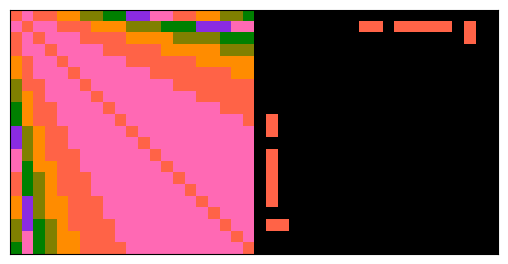

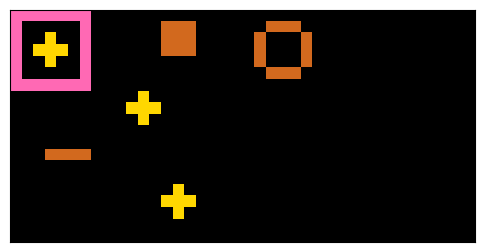

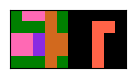

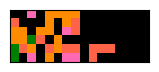

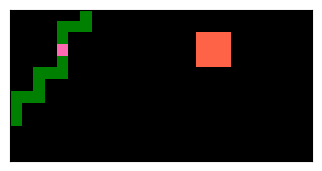

In [130]:
def get_kps_desc_serial(images: List[np.ndarray]) -> List[Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]]: 
    """ 
    Process multiple images to get keypoints and their descriptors. 

    Returns: 
        list: List of tuples containing keypoints and descriptors for each image. 
    """ 
    result = [] 
    for img in images: 
        kps_desc = get_kps_desc(img) 
        result.append(kps_desc) 
    return result


images_reference_set = [image1_out, image2_out, image3_out, image4_out, image5_out]
kps_desc = get_kps_desc_serial(images_reference_set)
for i in range(len(images_reference_set)):
    # print("\nImage", i)
    # print("Key points (x, y):")
    # print("x:", kps_desc[i][0][0])
    # print("y:", kps_desc[i][0][1])
    # print("Descriptors:\n", kps_desc[i][1])
    kps_binary = np.zeros_like(images_reference_set[i])
    kps_binary[kps_desc[i][0][0], kps_desc[i][0][1]] = 1
    h_grid(np.concatenate([images_reference_set[i], kps_binary], 1), scale=0.3)
    plt.show()

Matching the key points of the query and determining the similarity

In [131]:
#image to image determination of similarity
def similarity_measure(desc1: Any, desc2: Any) -> float:
    """
    Compute the similarity measure between two descriptors as mean of similarities of best matched kps.
    
    Returns:
        float: Similarity measure computed as the mean of the element-wise comparison.
    """
    return (desc1 == desc2).mean(-1)


def similarity(img1: np.ndarray, img2: np.ndarray) -> float:
    """
    Calculate similarity score between two images based on their keypoints and descriptors.
    
    Returns:
        float: Similarity score between the images.
    """
    kps1, desc1 = get_kps_desc(img1)
    kps2, desc2 = get_kps_desc(img2)
    
    sim = similarity_measure(desc1[:, np.newaxis], desc2[np.newaxis])   #similarities of kp to each kp in img2
    nearest_sim = np.max(sim, -1)  #similarity of most similar kp in img2
    similarity_score = np.mean(nearest_sim)  
    
    return similarity_score

print(similarity(image1_out, image1_in))
print(similarity(image3_out, image3_in))

1.0
0.3333333333333333


1.0


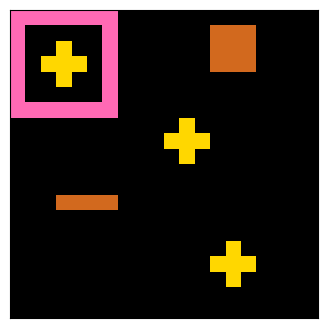

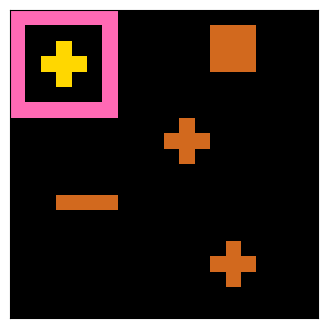

In [132]:
def most_similar(reference_image: np.ndarray, images: List[np.ndarray]) -> Tuple[np.ndarray, float]:
    """
    Find the most similar image to the reference image based on the similarity measure.
    
    Returns: 
        tuple: Tuple containing the most similar image and the similarity score.
    """
    highest_score = -1 
    most_similar_image = None 
    for img in images: 
        score = similarity(reference_image, img) 
        if score > highest_score: 
            highest_score = score 
            most_similar_image = img 
    return most_similar_image, highest_score

#Test
image_ref = image2_out
images_reference_set = [image1_in, image2_in, image3_in, image4_in, image5_in]

most_similar_image, highest_score = most_similar(image_ref, images_reference_set)
print(highest_score)
h_grid(image_ref, scale=0.2)
h_grid(most_similar_image, scale=0.2)

# Pixel description (OpenCV)

The OpenCV library contains a set of implementations of popular descriptors and additional functionalities for finding matches and for displaying processing results.

A good image descriptor should be invariant to the following variations:
- Translation
- Rotation
- Scaling
- Change illumination
- Change viewpoint or perspective
- Noise
- Change color (sometimes)

## Popular OpenCV Descriptors

Each of the descriptors in the OpenCV library has the following functions:
- detect () - to detect key points (unless the implementation does not have such functionality),
- compute () - to compute descriptors for key points,
- detectAndCompute () - function that returns key points and their descriptors for a given image (single-line calling of the above operations).



### Harris Corner Detector

Algorithm presented in the scientific article 'A Combined Corner and Edge Detector' in 1988 by authors Chris Harris and Mike Stephens.

The algorithm uses the sum of the changes in the intensity of adjacent pixels to find flat areas, edges, and corners. The first step in finding these areas is to expand the formula for the above sum into a Taylor series and then calculate a value based on the determinant and trace of the gradient matrix, which will directly indicate the classification of the area.



1. The sum of the intensities of adjacent pixels:
$$E(u,v) = \sum_{x,y} w(x,y) \, [I(x+u,y+v)-I(x,y)]^2$$
2. Expansion with Taylor series:
$$E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}$$
$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\ I_x I_y & I_y I_y \end{bmatrix}$$

where $I_x$ represents the partial derivative of the image intensity
$I(x,y)$ with respect to the x-coordinate.
3. Calculation of the final value:

$$R = det(M) - k(trace(M))^2$$
$$det(M) = \lambda_1 \lambda_2$$
$$trace(M) = \lambda_1 + \lambda_2$$


Determining whether a given area is a corner, edge or flat area is made in accordance with the following:

- if R is close to zero - the area is flat,
- if R is (much) less than zero, the area is an edge,
- if R is (much) greater than zero - area is a corner


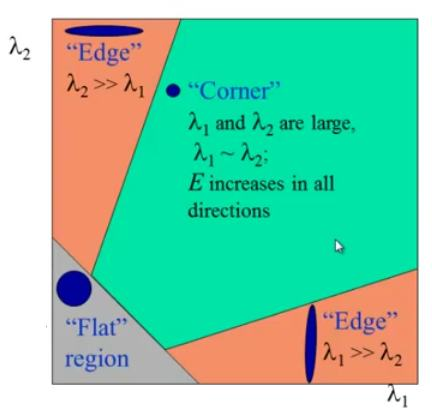

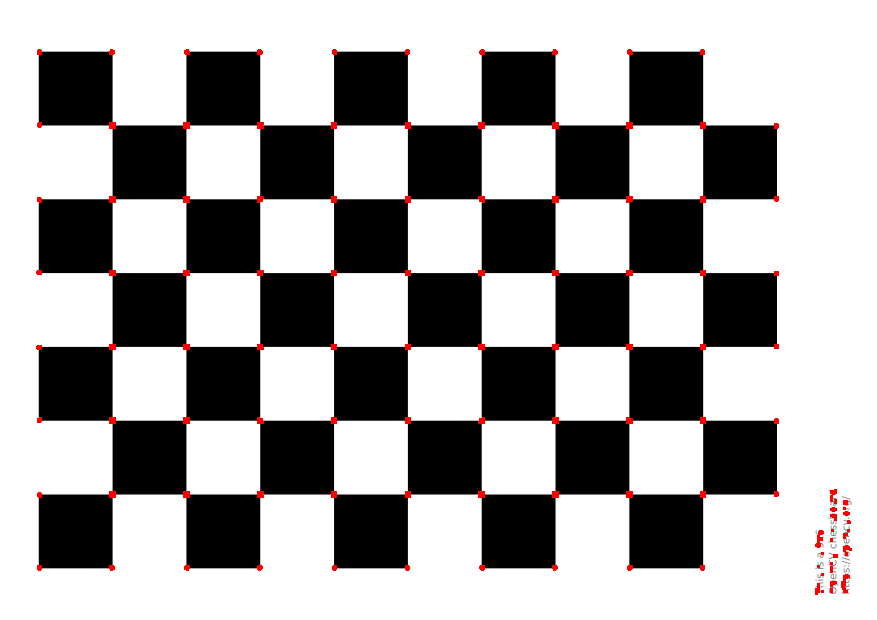

In [133]:
img_blocks = cv2.imread("chessboard.png", cv2.IMREAD_COLOR)
img_blocks = cv2.resize(img_blocks, None, fx=0.5, fy=0.5)
img_blocks_gray = cv2.cvtColor(img_blocks, cv2.COLOR_BGR2GRAY)
img_blocks_gray = img_blocks_gray.astype(np.float32)

dst = cv2.cornerHarris(img_blocks_gray, 3, 3, 0.04)  #src, blockSize-neighbourhood, ksize-for sobel, free parameter for harris detector
# result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
img_blocks[dst > 0.01 * dst.max()] = [0, 0, 255]
imshow(img_blocks)

### SIFT - Scale Invariant Feature Transform

The author of the algorithm is D.Lowe, who presented it for the first time in the work Distinctive Image Features from Scale-Invariant Keypoints in 2004.

It is an algorithm that determines key points and their descriptors based on gradients in their close surroundings. The next steps of the algorithm are as follows:

1. The input image is scaled multiple times (x1, x0.5, x0.25, x0.125) and then Gauss filters are made on each scale (eg size 2, 4, 6, 8). Thus, by considering different scales for finding keypoints, the keypoints found will be scale invariant.

2. The difference operation is performed between neighboring Gaussians in a given scale (directly on the image intensities).


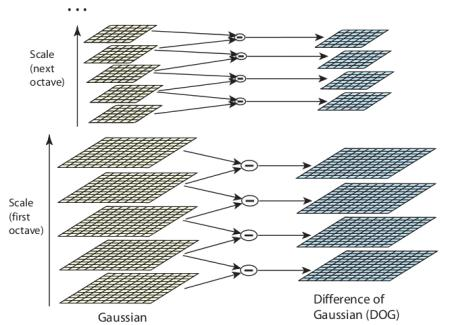

3. Each pixel is compared with its surroundings (eg 8 neighboring pixels - 3x3) and it is checked if a given pixel is an extreme value.

4. Similarly, the same pixel is compared with the pixels on a lower and higher scale (scale = Gaussian filter size).


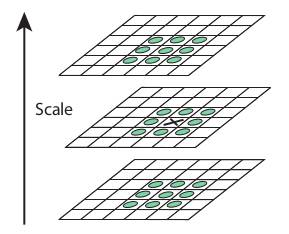

5. The extreme end values are **key point candidates**. To select key points, an additional filtering operation is performed based on the contrast of the pixel's surroundings.

6. For key points, their neighboring regions are chosen, and gradients are computed for each pixel within these regions. These gradients are used to calculate their magnitude and orientation. Then an **orientation histogram** with 36 bins covering 360 degrees is created.


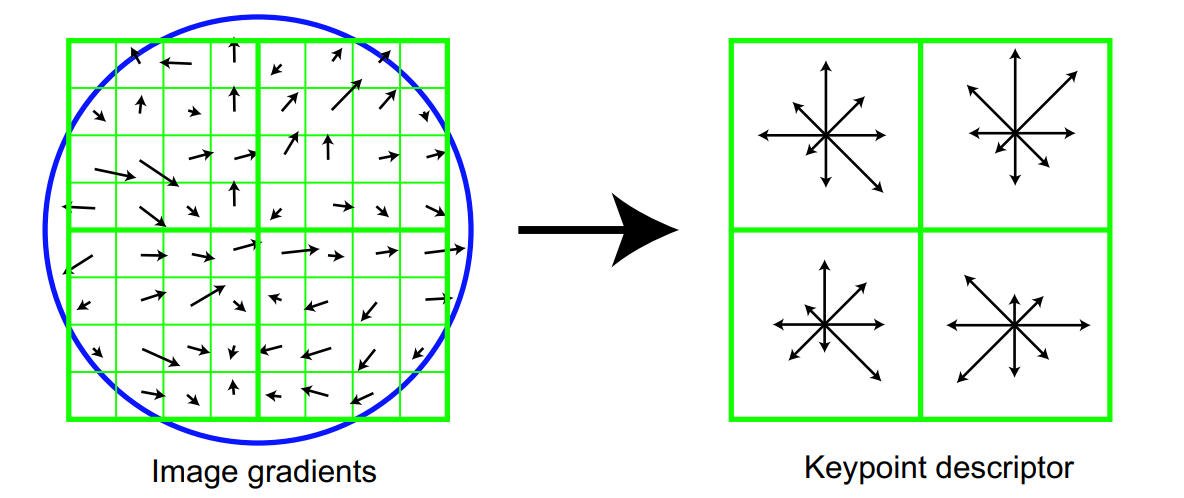

7. The resultant histogram invariably exhibits at least one prominent peak, which is subsequently designated as the keypoint's orientation. If there exist multiple peaks surpassing 80% of the maximum value, a new keypoint copy is generated for each of them, with each copy associated with its respective primary orientation.


8. The final stage involves the generation of a keypoint descriptor. To achieve this, the surrounding area is divided into subregions, within which both magnitude and orientation are computed. The keypoint's orientation is subtracted from each calculated orientation. Based on these values, an orientation histogram is constructed using 8 bins. For the illustration above, we have 4 **mini-regions** and each will have 8 values. Ultimately, the descriptor will have a size of 32 (each key point will have 32 values).


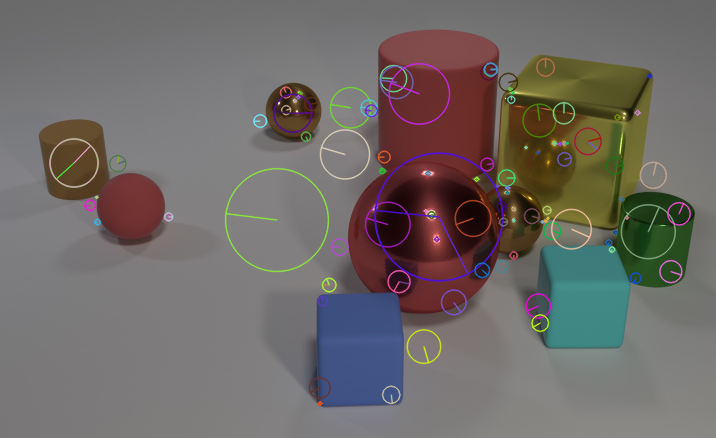

(126, 128)
[ 51.  10.   1.  25.  50.   1.   0.  17.  16.  35.  77. 151. 150.   9.
   0.   0. 131. 145.  65.  17.   6.   1.   0.   4.  19.  10.   1.   1.
   4.   6.   2.   4.  10.  33.  27.  20.  78.   5.   0.   7.  52.  11.
   6.  38. 151.  65.   8.  12. 151.  49.   3.   3.  33.  11.   7.  57.
  59.   5.   0.   0.   0.   6.   5.  11.   0.  56.  49.  11.  22.   4.
   0.   0.  10.  12.  12.  12. 127. 110.  73.  45. 116.   4.   0.   0.
   8.  18.  55. 151.  20.   1.   0.   0.   0.   0.   0.   8.   0.  24.
  22.   0.   0.   0.   0.   0.   2.  46.  20.   0.   1.   5.   9.   6.
   4.   6.   1.   0.   0.   1.   6.  13.   0.   0.   0.   0.   0.   0.
   0.   0.]


In [134]:
img_clevr = cv2.imread("clevr.jpg", cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp, desc = sift.detectAndCompute(img_clevr_gray, None)

img_clevr = cv2.drawKeypoints(
    img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
imshow(img_clevr)

print(desc.shape)
print(desc[0])

### BRIEF - Binary Robust Independent Elementary Features

The algorithm proposed in the research paper '' BRIEF: Binary Robust Independent
Elementary Features '' by the authors Michael Calonder, Vincent Lepetit, Christoph Strecha, and Pascal Fua.

The algorithm is used to calculate descriptors for a given pixel and its surroundings and does not include the stage of key point detection, so it must always be applied to known (previously discovered) key points.

The algorithm is as follows:

1. For a given neighborhood size (eg 3, 3), **n** random pairs are selected.


In [135]:
h([[0, 1, 2], [3, 4, 5], [6, 7, 8]])

In [136]:
n = 10

# all combinations
p = list(itertools.combinations(range(9), 2))

# only n random combinations
p = random.sample(p, n)

print(p)


[(2, 6), (2, 7), (2, 8), (2, 5), (1, 8), (0, 7), (1, 6), (5, 8), (6, 7), (0, 5)]


2. The neighborhood of the key point is selected.

In [137]:
x = np.array([[255, 100, 0], [20, 0, 100], [10, 255, 10]])
h(x)

3. For the key point, it is checked if the values from the previously selected pairs of neighbors are the same (greater).

In [138]:
x_flat = np.reshape(x, -1)
pairs = [(x_flat[pi[0]], x_flat[pi[1]]) for pi in p]

print("The values of all par:")
print(pairs)

bin_vals = [x == y for x, y in pairs]

print("\nThe compliance of the pixel values of par of neighbours:")
print(bin_vals)

brief_desc = np.array(bin_vals, np.int32)

print("\nFinal brief descriptor:")
print(brief_desc)

The values of all par:
[(0, 10), (0, 255), (0, 10), (0, 100), (100, 10), (255, 255), (100, 10), (100, 10), (10, 255), (255, 100)]

The compliance of the pixel values of par of neighbours:
[False, False, False, False, False, True, False, False, False, False]

Final brief descriptor:
[0 0 0 0 0 1 0 0 0 0]


#### BRIEF in OpenCV

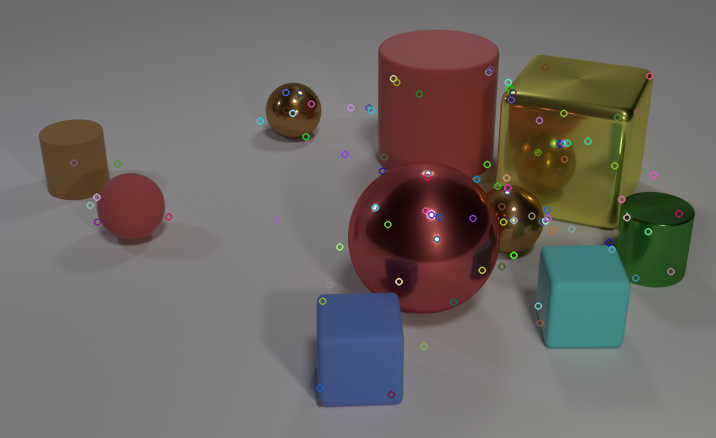


The size of the descriptor in bytes: 32
The number of random pairs of comparisons: 256


In [139]:
img_clevr = cv2.imread("clevr.jpg", cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(bytes=32)
kp = sift.detect(img_clevr_gray, None)
kp, desc = brief.compute(img_clevr_gray, kp)

img_clevr = cv2.drawKeypoints(img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
imshow(img_clevr)

print("\nThe size of the descriptor in bytes:", brief.descriptorSize())
print("The number of random pairs of comparisons:", brief.descriptorSize() * 8)

The OpenCV implementation operates on bits, but the data (due to the specificity of Python) are returned in the form of bytes. This means that if when creating the descriptor we choose its size as 32 bytes, the BRIEF will look for 256 pairs for each pixel neighborhood.

The result will be returned in bytes (which makes no difference, because the descriptors are compared with Hamming distance).

In [140]:
print(desc.shape)
print(desc[0])


(126, 32)
[231 254 149  26 243  86 254 102 101 130 143  87 151  41 241  35 150  48
  76  62 174  40  40 175 223 191 181 149  36 188 172 208]


### FAST - Features from Accelerated Segment Test

Algorithm for corner detection by means of a simple and quick test of the pixel's surroundings. Proposed in the paper 'Machine learning for high-speed corner detection' by Edward Rosten and Tom Drummond.

This approach is characterized by a very short duration of action and a relatively high effectiveness of action.

The algorithm performs the following operations:

1.The intensity of the next pixel is taken ($I (x, y)$) and the cut-off threshold is selected ($ \lambda_ {x, y} $), based on the intensity taken,

2. Then a radius and pixels are selected on a circle with this radius and center at (x, y).


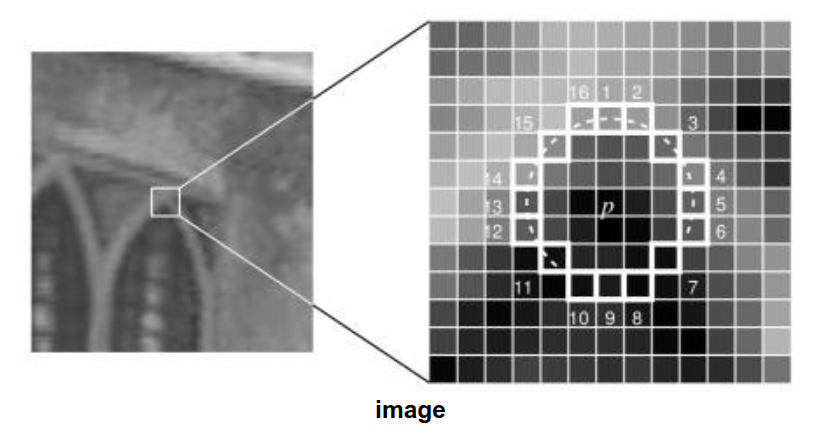

3. If the intensity **n** pixels of the pixels along the circle satisfy any of the following properties, then we say that this area has a corner:
$$I(x', y') > I(x, y) + \lambda_{x, y}$$
$$I(x', y') < I(x, y) - \lambda_{x, y}$$

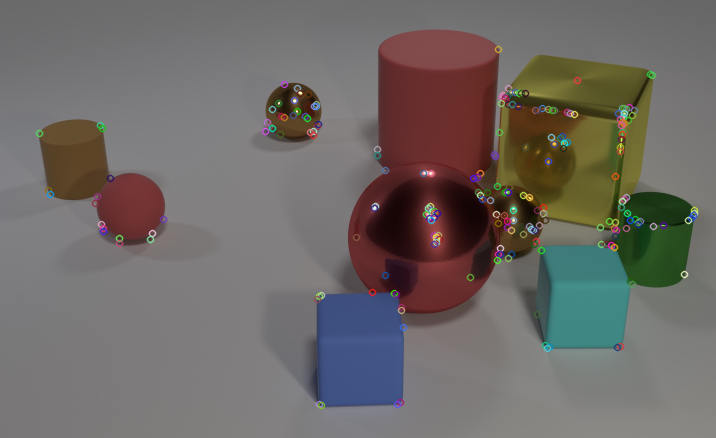

In [141]:
img_clevr = cv2.imread("clevr.jpg", cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

fast = cv2.FastFeatureDetector_create()
kp = fast.detect(img_clevr_gray, None)

img_clevr = cv2.drawKeypoints(img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
imshow(img_clevr)

### ORB - Oriented FAST and Rotated BRIEF

An algorithm that combines the approach proposed by FAST and BRIEF. Presented in ORB: An efficient alternative to SIFT or SURF by Ethan Rublee, Vincent Rabaud, Kurt Konolige and Gary R. Bradski.

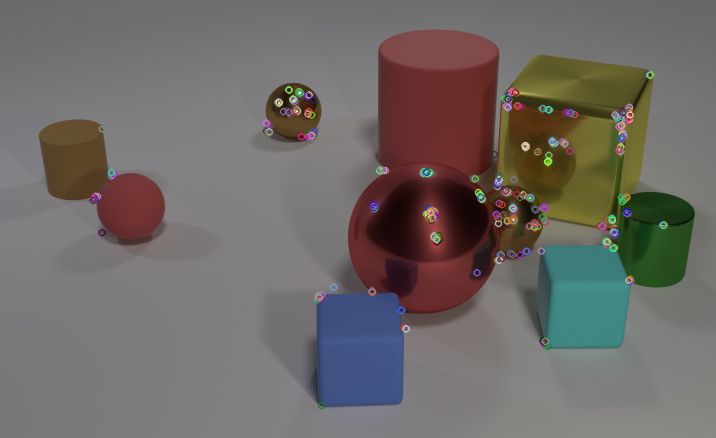

(468, 32)
[ 50  77  98 190  86 128 238 246 212   0 216 194  49 203 177  64 120 234
  19 203 200 187   6 255  48  44 170 136  61 187 112 168]


In [142]:
img_clevr = cv2.imread("clevr.jpg", cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create()
kp, desc = orb.detectAndCompute(img_clevr_gray, None)

img_clevr = cv2.drawKeypoints(img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
imshow(img_clevr)

print(desc.shape)
print(desc[0])

## Matching descriptors

The matching of key points is done on the basis of their descriptors. OpenCV includes an object implementation to find both best and k-best matches.

In order to obtain correct results, the appropriate descriptor similarity function should be used. For descriptors that operate in the Euclidean space, this may be the normal Euclidean distance. For descriptors such as BRISK, which produce binary descriptors, the Hamming distance would be a better proposition.


Let's load two sample images that show the same object from different angles:

In [ ]:
img_graf1 = cv2.imread("graf1.png", cv2.IMREAD_COLOR)
img_graf1 = cv2.resize(img_graf1, None, fx=0.5, fy=0.5)

img_graf2 = cv2.imread("graf2.png", cv2.IMREAD_COLOR)
img_graf2 = cv2.resize(img_graf2, None, fx=0.5, fy=0.5)

imshow(np.concatenate([img_graf1, img_graf2], 1))

In [ ]:
img_graf1_gray = cv2.cvtColor(img_graf1, cv2.COLOR_BGR2GRAY)
img_graf2_gray = cv2.cvtColor(img_graf2, cv2.COLOR_BGR2GRAY)

imshow(np.concatenate([img_graf1_gray, img_graf2_gray], 1))


Then, for their representation in the Grayscale color space, let's find the key points and their descriptors using the algorithms below.

In [145]:
sift = cv2.SIFT_create()  # kp + desc
orb = cv2.ORB_create()  # kp + desc
fast = cv2.FastFeatureDetector_create()  # only kp
star = cv2.xfeatures2d.StarDetector_create()  # only kp
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()  # only desc


In [146]:
sift_kp1, sift_desc1 = sift.detectAndCompute(img_graf1_gray, None)
sift_kp2, sift_desc2 = sift.detectAndCompute(img_graf2_gray, None)

orb_kp1, orb_desc1 = orb.detectAndCompute(img_graf1_gray, None)
orb_kp2, orb_desc2 = orb.detectAndCompute(img_graf2_gray, None)

fast_kp1 = fast.detect(img_graf1_gray, None)
fast_kp2 = fast.detect(img_graf2_gray, None)

star_kp1 = star.detect(img_graf1_gray, None)
star_kp2 = star.detect(img_graf2_gray, None)

print("\nSIFT:")
print("Number of key points in the first image:", len(sift_kp1))
print("Number of key points in the second image:", len(sift_kp2))

print("\nORB:")
print("Number of key points in the first image:", len(orb_kp1))
print("Number of key points in the second image:", len(orb_kp2))

print("\nFAST:")
print("Number of key points in the first image:", len(fast_kp1))
print("Number of key points in the second image:", len(fast_kp2))

print("\nSTAR:")
print("Number of key points in the first image:", len(star_kp1))
print("Number of key points in the second image:", len(star_kp2))


SIFT:
Number of key points in the first image: 1093
Number of key points in the second image: 1322

ORB:
Number of key points in the first image: 500
Number of key points in the second image: 500

FAST:
Number of key points in the first image: 3007
Number of key points in the second image: 3571

STAR:
Number of key points in the first image: 282
Number of key points in the second image: 325


In [147]:
def show_kp(kp1, kp2):
    img_kp1 = cv2.drawKeypoints(
        img_graf1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT
    )
    img_kp2 = cv2.drawKeypoints(
        img_graf2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT
    )

    imshow(np.concatenate([img_kp1, img_kp2], 1))

In [ ]:
print("\nSIFT Keypoints:\n")
show_kp(sift_kp1, sift_kp2)

print("\nORB Keypoints:\n")
show_kp(orb_kp1, orb_kp2)

print("\nFAST Keypoints:\n")
show_kp(fast_kp1, fast_kp2)

print("\nSTAR Keypoints:\n")
show_kp(star_kp1, star_kp2)

Additionally, for the FAST and STAR key points, let's count the BRIEF descriptors.

In [149]:
_, fast_brief_desc1 = brief.compute(img_graf1_gray, fast_kp1)
_, fast_brief_desc2 = brief.compute(img_graf2_gray, fast_kp2)

_, star_brief_desc1 = brief.compute(img_graf1_gray, star_kp1)
_, star_brief_desc2 = brief.compute(img_graf2_gray, star_kp2)


For the above generated data, we will check the best fit as well as the k-nearest matches, based on Euclidean and Hamming distance.


In [150]:
bf_l2 = cv2.BFMatcher(cv2.NORM_L2)
bf_hamming = cv2.BFMatcher(cv2.NORM_HAMMING)


### Closest match

In [151]:
def show_matches(bf, kp1, desc1, kp2, desc2, num_matches=30):
    matches = bf.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    matches = cv2.drawMatches(
        img_graf1,
        kp1,
        img_graf2,
        kp2,
        matches[:num_matches],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    imshow(matches)

In [ ]:
# SIFT keypoints
show_matches(bf_l2, sift_kp1, sift_desc1, sift_kp2, sift_desc2, 50)


In [ ]:
# ORB keypoints
show_matches(bf_l2, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)
show_matches(bf_hamming, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)


In [ ]:
# FAST keypoints
show_matches(bf_l2, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)
show_matches(bf_hamming, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)


In [ ]:
# STAR keypoints
show_matches(bf_l2, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)
show_matches(bf_hamming, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)


### K-nearest matches

In [156]:
def show_knn_matches(bf, kp1, desc1, kp2, desc2, num_matches=30, k=2):
    matches = bf.knnMatch(desc1, desc2, k=k)
    # taking k = 2 you can use additional filtering described in the article on SIFT
    matches = [[m] for m, n in matches if m.distance < 0.75 * n.distance]
    matches = cv2.drawMatchesKnn(
        img_graf1,
        kp1,
        img_graf2,
        kp2,
        matches[:num_matches],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    imshow(matches)

In [ ]:
# SIFT keypoints
show_knn_matches(bf_l2, sift_kp1, sift_desc1, sift_kp2, sift_desc2, 100)


In [ ]:
# ORB keypoints
show_knn_matches(bf_l2, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)
show_knn_matches(bf_hamming, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)


In [ ]:
# FAST keypoints
show_knn_matches(bf_l2, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)
show_knn_matches(bf_hamming, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)


In [ ]:
# STAR keypoints
show_knn_matches(bf_l2, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)
show_knn_matches(bf_hamming, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)


## Task 3

Implement an algorithm that will find the most similar images to your query. The algorithm should work for any key point detector (a descriptor with a key point detection function) and a descriptor (an object that returns its descriptor for a given key point).

Use the Cats and Dogs (Microsoft) dataset available on the [site](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Sub-items to be performed:
- create a data set by choosing 20 images of cats and dogs randomly,
- create a query by selecting a random image of a dog or cat (this image should not be included in the above set),
- write an algorithm to determine the similarity of the query and all images in the data set,
- run an algorithm that will find the 5 most similar images,
- check how many of the found photos are of the same class as the inquiries (cat vs dog),
- compare the results for at least 2 descriptors.
- you can propose your own key point detector or descriptor, in this case add comments describing the next stages of processing.



In [227]:
import glob
import os
import random
import cv2
import numpy as np
from typing import List, Tuple, Any
from matplotlib import pyplot as plt


# Load images from specified directory
all_images = glob.glob('C:/STUDIA/CNN-Rob/CNN/ForwardNN-cats_dogs/cats_and_dogs_small/test/*/*.jpg') 
random.shuffle(all_images) 
dataset_images = all_images[:20] 
query_image = random.choice(all_images[20:]) 

def read_image(image_path: str, target_size: Tuple[int, int] = (256, 256)) -> Tuple[str, np.ndarray]: 
    """ Read an image from the given path, resize it to the target size, and convert to grayscale. """ 
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    image = cv2.resize(image, target_size) 
    return image_path, image

# Read images
images = [read_image(image_path) for image_path in dataset_images]
query_filename, query_image = read_image(query_image)


class KeypointDescriptor:
    def __init__(self, detector: Any, descriptor: Any = None):
        self.detector = detector
        self.descriptor = descriptor

    def detect(self, image: np.ndarray) -> List[cv2.KeyPoint]:
        keypoints = self.detector.detect(image, None)
        return keypoints

    def compute(self, image: np.ndarray, keypoints: List[cv2.KeyPoint]) -> np.ndarray:
        if self.descriptor:
            _, descriptors = self.descriptor.compute(image, keypoints)
            return descriptors
        else:
            _, descriptors = self.detector.compute(image, keypoints)
            return descriptors

    def detect_and_compute(self, image: np.ndarray) -> Tuple[List[cv2.KeyPoint], np.ndarray]:
        keypoints = self.detect(image)
        descriptors = self.compute(image, keypoints)
        return keypoints, descriptors


def match_descriptors(desc1: np.ndarray, desc2: np.ndarray) -> float:
    if desc1 is None or desc2 is None:
        return 0.0
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return len(good_matches) / len(matches)


def compute_similarity(query_image: np.ndarray, dataset_images: List[Tuple[str, np.ndarray]], descriptor: KeypointDescriptor) -> List[Tuple[str, float]]:
    kp1, desc1 = descriptor.detect_and_compute(query_image)
    
    similarities = []
    for image_path, image in dataset_images:
        kp2, desc2 = descriptor.detect_and_compute(image)
        score = match_descriptors(desc1, desc2)
        similarities.append((image_path, score))

    return sorted(similarities, key=lambda x: x[1], reverse=True)


def find_most_similar_images(reference_image: np.ndarray, images: List[Tuple[str, np.ndarray]], descriptor: KeypointDescriptor, top_n: int = 5) -> List[Tuple[str, float]]:
    similarity_results = compute_similarity(reference_image, images, descriptor)
    return similarity_results[:top_n]


def display_images(images: List[Tuple[str, float]], target_size: Tuple[int, int] = (256, 256)): 
    loaded_images = [cv2.imread(filename, cv2.IMREAD_COLOR) for filename, _ in images] 
    resized_images = [cv2.resize(img, target_size) for img in loaded_images] 
    concatenated_image = np.concatenate(resized_images, axis=1)
    plt.figure(figsize=(20, 10)) 
    plt.imshow(concatenated_image, cmap='gray') 
    plt.axis('off') 
    plt.show()
    
    
def get_image_class(image_path: str) -> str: 
    """ Determine the class of the image based on the last folder name in its path. """ 
    return os.path.basename(os.path.dirname(image_path))



sift_descriptor = KeypointDescriptor(cv2.SIFT_create())  #kp + desc
orb_descriptor = KeypointDescriptor(cv2.ORB_create())   #kp + desc
fast = cv2.FastFeatureDetector_create()  #kp
star = cv2.xfeatures2d.StarDetector_create()  #kp
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()  #desc
fast_brief_descriptor = KeypointDescriptor(fast, brief)  
star_brief_descriptor = KeypointDescriptor(star, brief)
print(query_filename)

C:/STUDIA/CNN-Rob/CNN/ForwardNN-cats_dogs/cats_and_dogs_small/test\cats\cat.1586.jpg


Most similar images using SIFT descriptor + query image:


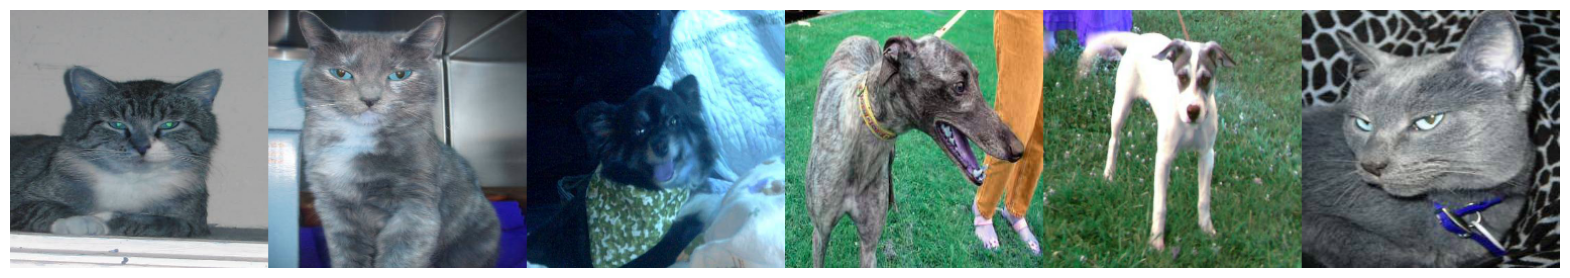

Images from the same class: 0.4


In [228]:
# Find the most similar images using SIFT descriptor
most_similar_images = find_most_similar_images(query_image, images, sift_descriptor)
similar_and_query = most_similar_images + [(query_filename, query_image)]
print("Most similar images using SIFT descriptor + query image:")
display_images(similar_and_query)

similar_images_classes = np.array([get_image_class(filename) for filename, _ in most_similar_images])
query_image_class = get_image_class(query_filename)

occurences = np.sum(similar_images_classes == query_image_class)
print("Images from the same class:", occurences/len(similar_images_classes))     

Most similar images using ORB descriptor + query image:


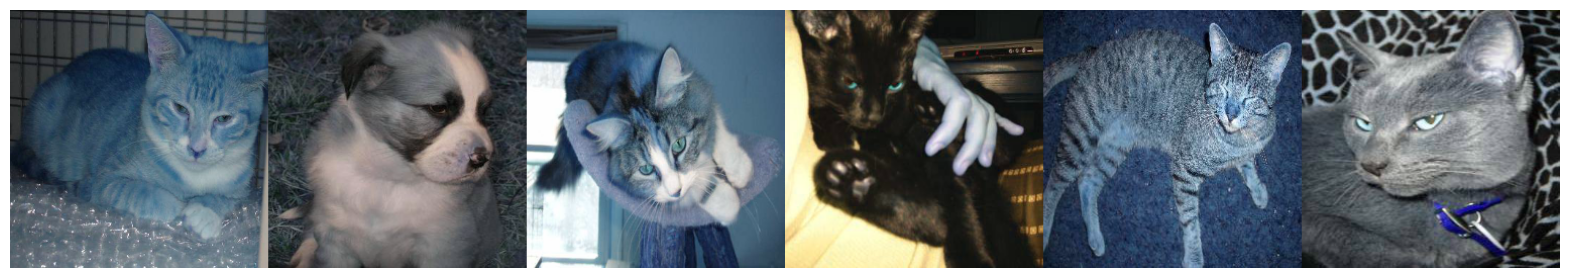

Images from the same class: 0.8


In [229]:
# Find the most similar images using ORB descriptor
most_similar_images = find_most_similar_images(query_image, images, orb_descriptor)
similar_and_query = most_similar_images + [(query_filename, query_image)]
print("Most similar images using ORB descriptor + query image:")
display_images(similar_and_query)

similar_images_classes = np.array([get_image_class(filename) for filename, _ in most_similar_images])
query_image_class = get_image_class(query_filename)

occurences = np.sum(similar_images_classes == query_image_class)
print("Images from the same class:", occurences/len(similar_images_classes))    

Most similar images using FAST and BRIEF descriptor + query image:


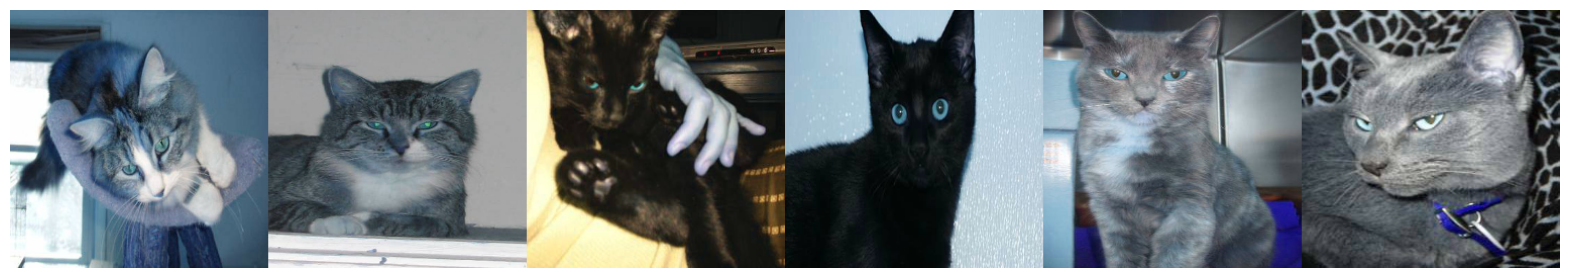

Images from the same class: 1.0


In [230]:
# Find the most similar images using FAST and BRIEF descriptor
most_similar_images = find_most_similar_images(query_image, images, fast_brief_descriptor)
similar_and_query = most_similar_images + [(query_filename, query_image)]
print("Most similar images using FAST and BRIEF descriptor + query image:")
display_images(similar_and_query)

similar_images_classes = np.array([get_image_class(filename) for filename, _ in most_similar_images])
query_image_class = get_image_class(query_filename)

occurences = np.sum(similar_images_classes == query_image_class)
print("Images from the same class:", occurences/len(similar_images_classes))    

Most similar images using STAR and BRIEF descriptor  + query image:


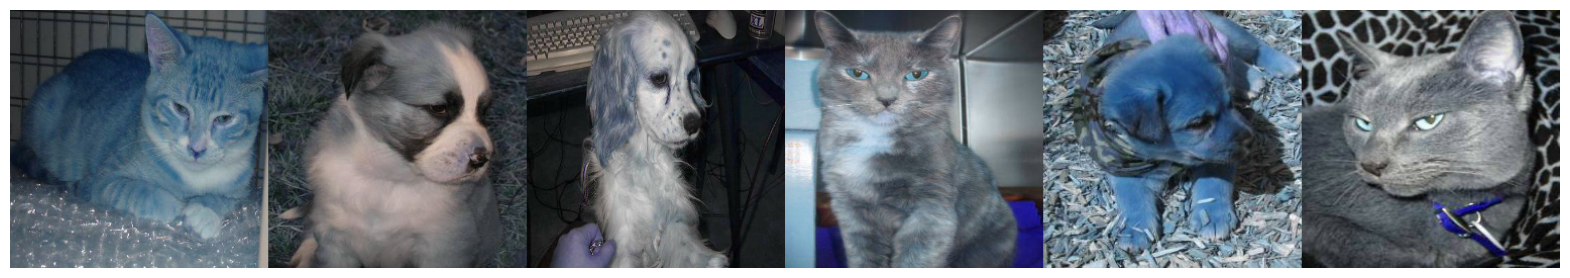

Images from the same class: 0.4


In [231]:
# Find the most similar images using STAR and BRIEF descriptor
most_similar_images = find_most_similar_images(query_image, images, star_brief_descriptor)
similar_and_query = most_similar_images + [(query_filename, query_image)]
print("Most similar images using STAR and BRIEF descriptor  + query image:")
display_images(similar_and_query)

similar_images_classes = np.array([get_image_class(filename) for filename, _ in most_similar_images])
query_image_class = get_image_class(query_filename)

occurences = np.sum(similar_images_classes == query_image_class)
print("Images from the same class:", occurences/len(similar_images_classes))    